In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import gseapy as gp

In [106]:
GENESHOT_URL = 'https://maayanlab.cloud/geneshot/api/search'
terms = ["IBD",
         "inflammatory bowel disease", 
         "ulcerative colitis", 
         "Crohn disease"]
data={}

In [107]:

for term in terms:
    try:
        payload = {"rif": "generif", "term": term}
        response = requests.post(GENESHOT_URL, json=payload)
        response.raise_for_status()  # Checks for errors in the HTTP response
        results = response.json()
        
        if 'gene_count' in results:
            data = {**data, **results['gene_count']}
            print(f'The answer to the term "{term}" have the key "gene_count".')

        else:
            print(f'The answer to the term "{term}" does not have the key "gene_count".')

    except requests.exceptions.RequestException as e:
            print(f'Error in making the request for the term"{term}": {e}')

The answer to the term "IDB" have the key "gene_count".
The answer to the term "inflammatory bowel disease" have the key "gene_count".
The answer to the term "ulcerative colitis" have the key "gene_count".
The answer to the term "Crohn disease" have the key "gene_count".


In [109]:
df = pd.DataFrame.from_dict(data, orient='index', columns=["Pubmed_IDs", "GeneRif"])
df = df.sort_values(by="GeneRif")
df.reset_index(inplace=True)
df.rename(columns={"index": "Gene_names"}, inplace=True)
duplicates = df.duplicated(subset="Gene_names", keep=False) #Check for duplicates in Gene_names column
any(duplicates)

False

In [ ]:
gwas_IBD = pd.read_csv("./data/EFO_0003767_associations_export_IBD.tsv", sep="\t")
xenium_colon= pd.read_csv("./data/Xenium_hColon_v1_metadata.csv")
disgenet_IBD = pd.read_csv("./results/disgenet_IBD_genes.csv")

gwas_IBD_genes_array = gwas_IBD["mappedGenes"].str.split(",").str[0]
disgenet_IBD_genes = disgenet_IBD["gene_symbol"]
gwas_IBD_genes = set(gwas_IBD["mappedGenes"].str.split(",").str[0])
xenium_colon_genes = set(xenium_colon["Gene"])
pubmed_genes = set(df["Gene_names"])

venn_diagram = venn3([gwas_IBD_genes, pubmed_genes, xenium_colon_genes], set_labels=('GWAS_catalog', 'PubMed', 'xenium_panel'))
plt.show()

In [68]:
df.to_csv('./results/Pubmed_IBD_genes.csv', index=False)

In [66]:
top_10_genes = df.loc[df['Pubmed_IDs'].nlargest(30).index]
top_10_genes

,Gene_names,Pubmed_IDs,GeneRif
604,NOD2,197,0.185325
727,ATG16L1,68,0.319249
542,IL23R,62,0.144186
197,ACE2,55,0.074124
48,TNF,50,0.007771
124,SIRT1,49,0.034410
603,IL37,37,0.184080
762,IRGM,36,0.391304
144,S100A9,35,0.071138
116,CYP2C19,31,0.028131


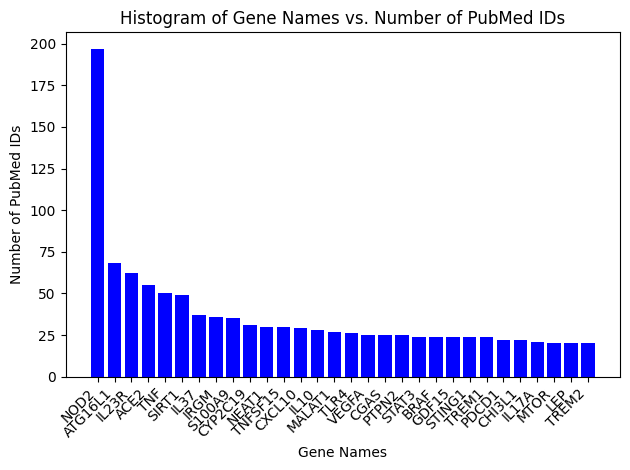

In [67]:
plt.bar(top_10_genes["Gene_names"], top_10_genes["Pubmed_IDs"], color='blue')
plt.xlabel('Gene Names')
plt.ylabel('Number of PubMed IDs')
plt.title('Histogram of Gene Names vs. Number of PubMed IDs')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

In [86]:
def to_json_serializable(objet):
    if isinstance(objet, pd.DataFrame):
        return objet.to_dict(orient='records')
    else:
        raise TypeError(f"Objeto no serializable: {type(objet)}")
    
gene_list_ibd_pudmed = json.dumps(pd.DataFrame(df["Gene_names"]),default=to_json_serializable )

In [87]:
GENESHOT_URL = 'https://maayanlab.cloud/geneshot/api/associate'

payload = {
  "gene_list": gene_list_ibd_pudmed,
  "similarity": "coexpression" 
}
response = requests.post(GENESHOT_URL, json=payload)

data = json.loads(response.text)

{'association': {'ABCD1P5': {'publications': 0, 'simScore': 0.20880678296089172, 'topGenes': {}, 'topScores': {}}, 'AC005307.3': {'publications': 0, 'simScore': 0.2119719684123993, 'topGenes': {}, 'topScores': {}}, 'AC008984.6': {'publications': 0, 'simScore': 0.19718757271766663, 'topGenes': {}, 'topScores': {}}, 'ADAMTS20': {'publications': 187, 'simScore': 0.2111498862504959, 'topGenes': {}, 'topScores': {}}, 'AKR1B1P4': {'publications': 0, 'simScore': 0.20637835562229156, 'topGenes': {}, 'topScores': {}}, 'ALG1L7P': {'publications': 0, 'simScore': 0.19402214884757996, 'topGenes': {}, 'topScores': {}}, 'ARID3B': {'publications': 139, 'simScore': 0.2151046246290207, 'topGenes': {}, 'topScores': {}}, 'ATP4A': {'publications': 31832, 'simScore': 0.21218563616275787, 'topGenes': {}, 'topScores': {}}, 'BEND4': {'publications': 32, 'simScore': 0.20962008833885193, 'topGenes': {}, 'topScores': {}}, 'BLM': {'publications': 509, 'simScore': 0.2079700082540512, 'topGenes': {}, 'topScores': {}

In [96]:
genes = []
publications = []
simScores = []

# Iterate through the data and fill in the lists.
for gene, info in data['association'].items():
    genes.append(gene)
    publications.append(info['publications'])
    simScores.append(info['simScore'])

# Create the DataFrame
df_assoc = pd.DataFrame({
    'Gene': genes,
    'Publications': publications,
    'SimScore': simScores
    # Agregate more columns if you need it
})

print(df_assoc)

           Gene  Publications  SimScore
0       ABCD1P5             0  0.208807
1    AC005307.3             0  0.211972
2    AC008984.6             0  0.197188
3      ADAMTS20           187  0.211150
4      AKR1B1P4             0  0.206378
..          ...           ...       ...
195       WNT8A          1651  0.374658
196       WRBP1             0  0.281564
197        ZIC3           606  0.216490
198     ZNF705D             2  0.197806
199     ZSCAN10            56  0.276772

[200 rows x 3 columns]


In [98]:
df_assoc.sort_values(by='SimScore', ascending=False)

,Gene,Publications,SimScore
52,FGF4,3217,0.376468
195,WNT8A,1651,0.374658
125,OR5H7P,0,0.360973
124,OR5H6,0,0.345974
179,TBX22,463,0.337573
...,...,...,...
173,SOX3,1556,0.193778
182,TDGF1P7,0,0.193298
10,BUB1,2170,0.192944
149,RP11-390F4.2,0,0.192608


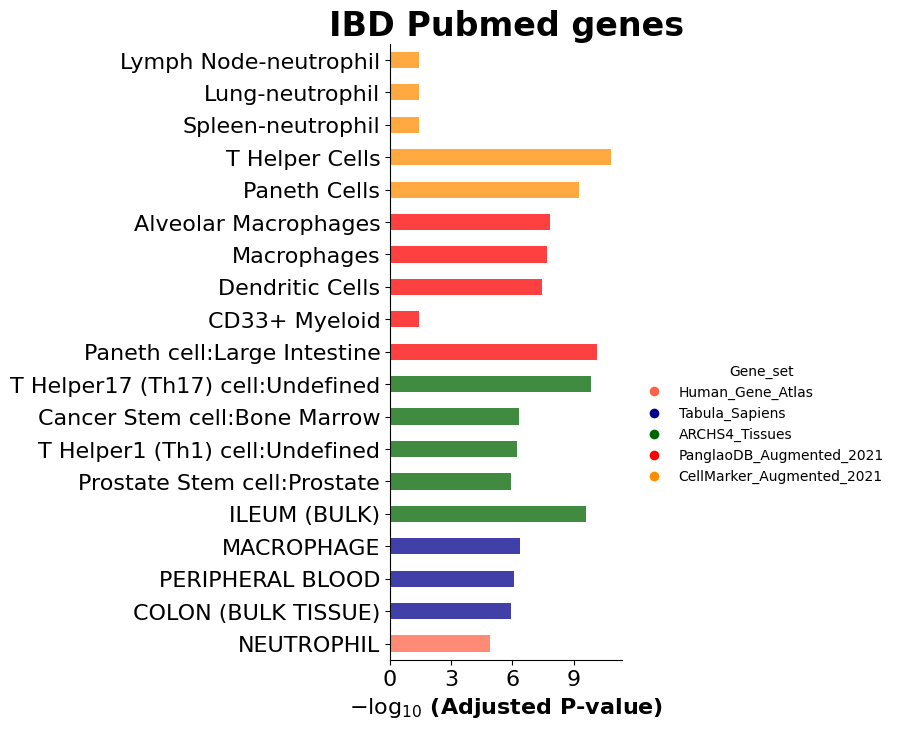

In [119]:
enr = gp.enrichr(gene_list= df["Gene_names"],
                 gene_sets=['Human_Gene_Atlas','Tabula_Sapiens', 'PanglaoDB_Augmented_2021', 
                            'CellMarker_Augmented_2021','ARCHS4_Tissues'],
                 organism='human',
                 outdir=None,
                )

ax = gp.barplot(enr.results,
              title="IBD Pubmed genes",
              column="Adjusted P-value",
              group='Gene_set',
              size=10,
              top_term=5,
              figsize=(3,8),
              color = {'Human_Gene_Atlas': 'tomato', 
                       'Tabula_Sapiens':'darkblue',
                        'PanglaoDB_Augmented_2021':'red',
                        'CellMarker_Augmented_2021':'darkorange',
                        'ARCHS4_Tissues': 'darkgreen'}
             )

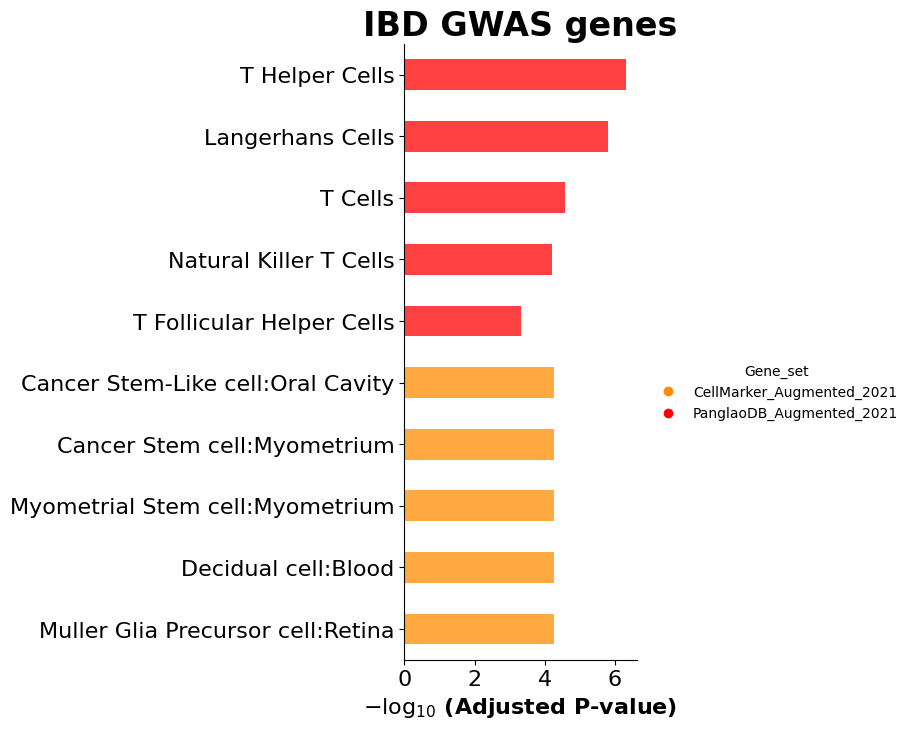

In [125]:
enr = gp.enrichr(gene_list= gwas_IBD_genes_array[1:],
                 gene_sets=['Human_Gene_Atlas','Tabula_Sapiens', 'PanglaoDB_Augmented_2021', 
                            'CellMarker_Augmented_2021','ARCHS4_Tissues'],
                 organism='human',
                 outdir=None,
                )

ax = gp.barplot(enr.results,
              title="IBD GWAS genes",
              column="Adjusted P-value",
              group='Gene_set',
              size=10,
              top_term=5,
              figsize=(3,8),
              color = {'Human_Gene_Atlas': 'tomato', 
                       'Tabula_Sapiens':'darkblue',
                        'PanglaoDB_Augmented_2021':'red',
                        'CellMarker_Augmented_2021':'darkorange',
                        'ARCHS4_Tissues': 'darkgreen'}
             )

c:\Users\Brise\AppData\Local\Programs\Python\Python312\Lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


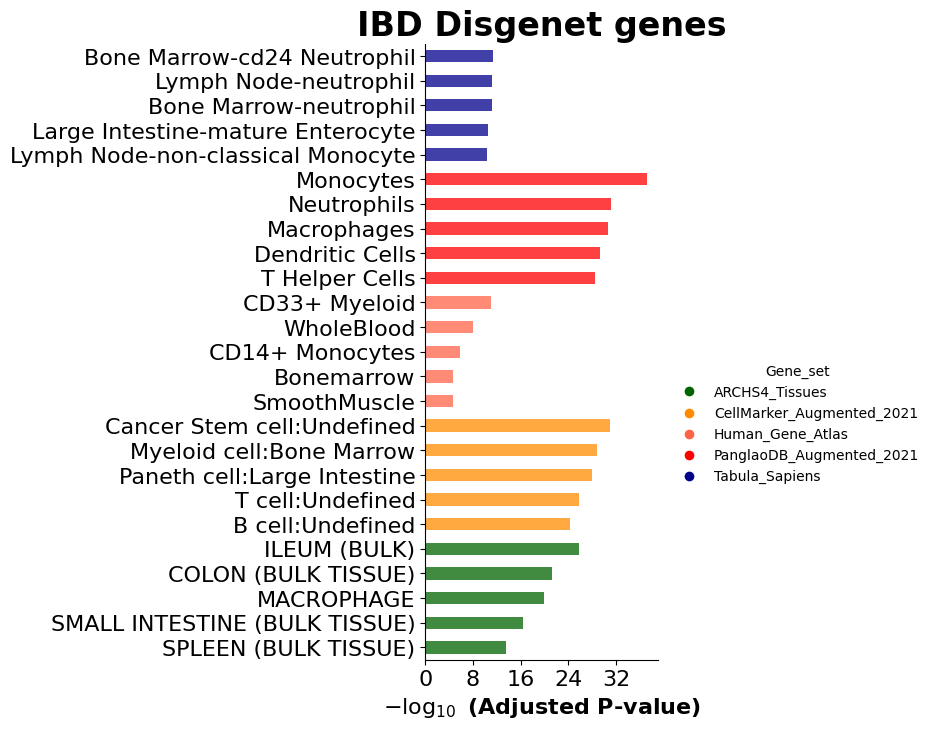

In [6]:
enr = gp.enrichr(gene_list= disgenet_IBD_genes,
                 gene_sets=['Human_Gene_Atlas','Tabula_Sapiens', 'PanglaoDB_Augmented_2021', 
                            'CellMarker_Augmented_2021','ARCHS4_Tissues'],
                 organism='human',
                 outdir=None,
                )

ax = gp.barplot(enr.results,
              title="IBD Disgenet genes",
              column="Adjusted P-value",
              group='Gene_set',
              size=10,
              top_term=5,
              figsize=(3,8),
              color = {'Human_Gene_Atlas': 'tomato', 
                       'Tabula_Sapiens':'darkblue',
                        'PanglaoDB_Augmented_2021':'red',
                        'CellMarker_Augmented_2021':'darkorange',
                        'ARCHS4_Tissues': 'darkgreen'}
             )